<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#프로젝트-:-뉴스-기사-클러스터,-시각화" data-toc-modified-id="프로젝트-:-뉴스-기사-클러스터,-시각화-1">프로젝트 : 뉴스 기사 클러스터, 시각화</a></span><ul class="toc-item"><li><span><a href="#과제" data-toc-modified-id="과제-1.1">과제</a></span></li><li><span><a href="#풀이" data-toc-modified-id="풀이-1.2">풀이</a></span><ul class="toc-item"><li><span><a href="#뉴스-기사-읽어오기,-전처리" data-toc-modified-id="뉴스-기사-읽어오기,-전처리-1.2.1">뉴스 기사 읽어오기, 전처리</a></span></li><li><span><a href="#전처리-완료된-collection을-pickle로-저장하기" data-toc-modified-id="전처리-완료된-collection을-pickle로-저장하기-1.2.2">전처리 완료된 collection을 pickle로 저장하기</a></span></li><li><span><a href="#DTM,-TDM,-TWM" data-toc-modified-id="DTM,-TDM,-TWM-1.2.3">DTM, TDM, TWM</a></span></li><li><span><a href="#DTM,-TDM,-TWM-등-객체를-pickle로-저장하기" data-toc-modified-id="DTM,-TDM,-TWM-등-객체를-pickle로-저장하기-1.2.4">DTM, TDM, TWM 등 객체를 pickle로 저장하기</a></span><ul class="toc-item"><li><span><a href="#defaultdict-pickle-저장-테스트" data-toc-modified-id="defaultdict-pickle-저장-테스트-1.2.4.1">defaultdict pickle 저장 테스트</a></span></li></ul></li><li><span><a href="#EM(expectation,-maximization)-=&gt;-numpy로-속도-개선" data-toc-modified-id="EM(expectation,-maximization)-=>-numpy로-속도-개선-1.2.5">EM(expectation, maximization) =&gt; numpy로 속도 개선</a></span></li><li><span><a href="#어휘-클러스터" data-toc-modified-id="어휘-클러스터-1.2.6">어휘 클러스터</a></span></li><li><span><a href="#시각화" data-toc-modified-id="시각화-1.2.7">시각화</a></span></li></ul></li></ul></li></ul></div>

## 프로젝트 : 뉴스 기사 클러스터, 시각화

### 과제

- 뉴스 데이터에 적용하기 (iter=10)


- WordCloud 만들기(명사만) => SSE 확인


- K=2가 아닌, < 10까지 변화 시키기

### 풀이

#### 뉴스 기사 읽어오기, 전처리

In [1]:
import os
from collections import defaultdict
from math import log
from math import exp
from random import sample

In [2]:
import pickle

In [3]:
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [12]:
from functions.naver import NewsScraping

from functions.info_retrieval import max_tf, raw_idf
from functions.info_retrieval import smoothig_idf
from functions.info_retrieval import clean_collection
from functions.info_retrieval import extend_lexicon
from functions.info_retrieval import inverted_index_with_tf
from functions.info_retrieval import get_tdm_from_dtm
from functions.info_retrieval import tdm2twm
from functions.info_retrieval import evaluate_idf
from functions.info_retrieval import save_pickle

In [5]:
import matplotlib.pyplot as plt

In [6]:
category = {
    '정치': '00',
    '경제': '01',
    '사회': '02',
    '생활문화': '03',
    '세계': '04',
    'IT과학': '05'
}

inverse_category = {
    '00': '정치',
    '01': '경제',
    '02': '사회',
    '03': '생활문화',
    '04': '세계',
    '05': 'IT과학'
}

In [7]:
news = NewsScraping()

In [8]:
filenames = news.get_filenames(all_folder=True)
len(filenames)

600

In [9]:
collection = []   # tuple(filename, content)들의 list

for filename in filenames:
    collection.append((filename.split("/")[-1], news.get_content(filename)))
    
len(collection)

600

In [10]:
cleaned_collection = clean_collection(collection)

In [11]:
extended_collection = []
corpus_count = len(cleaned_collection)

for idx, (filename, corpus) in enumerate(cleaned_collection):
    extended_lexicon = extend_lexicon(corpus)
    extended_collection.append([filename, extended_lexicon])
    if (idx + 1) % 30 == 0:
        print(corpus_count, "개 documents 중", idx + 1, "개 documents의 lexicon 추출 완료")

print(idx + 1, "개 documents의 lexicon 추출 완료")

600 개 documents 중 30 개 documents의 lexicon 추출 완료
600 개 documents 중 60 개 documents의 lexicon 추출 완료
600 개 documents 중 90 개 documents의 lexicon 추출 완료
600 개 documents 중 120 개 documents의 lexicon 추출 완료
600 개 documents 중 150 개 documents의 lexicon 추출 완료
600 개 documents 중 180 개 documents의 lexicon 추출 완료
600 개 documents 중 210 개 documents의 lexicon 추출 완료
600 개 documents 중 240 개 documents의 lexicon 추출 완료
600 개 documents 중 270 개 documents의 lexicon 추출 완료
600 개 documents 중 300 개 documents의 lexicon 추출 완료
600 개 documents 중 330 개 documents의 lexicon 추출 완료
600 개 documents 중 360 개 documents의 lexicon 추출 완료
600 개 documents 중 390 개 documents의 lexicon 추출 완료
600 개 documents 중 420 개 documents의 lexicon 추출 완료
600 개 documents 중 450 개 documents의 lexicon 추출 완료
600 개 documents 중 480 개 documents의 lexicon 추출 완료
600 개 documents 중 510 개 documents의 lexicon 추출 완료
600 개 documents 중 540 개 documents의 lexicon 추출 완료
600 개 documents 중 570 개 documents의 lexicon 추출 완료
600 개 documents 중 600 개 documents의 lexicon 추출 완료
600 개 documents의 lexico

#### 전처리 완료된 collection을 pickle로 저장하기

In [13]:
save_pickle({"news_collection": extended_collection}, save_dir="naver_news/pickle/")

naver_news/pickle/news_collection.pickle is saved.


In [14]:
# with open("naver_news/pickle/extended_collection.pickle", "wb") as f:
#     pickle.dump(extended_collection, f)

In [15]:
# pickle이 정상적으로 save 및 load 되는지 테스트
with open("naver_news/pickle/news_collection.pickle", "rb") as f:
    news_collection = pickle.load(f)

#### DTM, TDM, TWM

In [16]:
global_lexicon, global_posting, global_document, dtm = inverted_index_with_tf(news_collection)

In [17]:
tdm = get_tdm_from_dtm(dtm)

In [18]:
twm, dtw = tdm2twm(tdm, global_document)

In [19]:
global_lexicon_idf, global_document_weight = evaluate_idf(global_lexicon, global_posting, global_document)

#### DTM, TDM, TWM 등 객체를 pickle로 저장하기

In [20]:
pickle_object = {
    "global_lexicon": global_lexicon,
    "global_posting": global_posting,
    "global_document": global_document,
    "dtm": dtm,
    "tdm":tdm,
    "twm":twm,
    "dtw":dtw,
    "global_lexicon_idf":global_lexicon_idf,
    "global_document_weight":global_document_weight
}

In [21]:
save_pickle(pickle_object, save_dir="naver_news/pickle/")

naver_news/pickle/global_lexicon.pickle is saved.
naver_news/pickle/global_posting.pickle is saved.
naver_news/pickle/global_document.pickle is saved.
naver_news/pickle/dtm.pickle is saved.
naver_news/pickle/tdm.pickle is saved.
naver_news/pickle/twm.pickle is saved.
naver_news/pickle/dtw.pickle is saved.
naver_news/pickle/global_lexicon_idf.pickle is saved.
naver_news/pickle/global_document_weight.pickle is saved.


In [22]:
# # pickle로 저장 가능한 Object에 제한이 있음. 
# # ddefaultdict(lambda: defaultdict(int)) 내에 있는 lambda 함수 때문에 pickle 저장 시 에러가 발생함
# # pickle_object를 인자로 전달 시 defaultdict를 일반 dict로 변환해서 호출해야 함
# for pickle_name, pickle_obj in pickle_object.items():
#     file_path = "naver_news/pickle/" + pickle_name + ".pickle"
#     with open(file_path, "wb") as f:
#         pickle.dump(pickle_obj, f)
#         print(file_path)

##### defaultdict pickle 저장 테스트

In [165]:
# a = defaultdict(lambda: defaultdict(int))

# for i in range(5):
#     for j in range(5):
#         a[i][j] = i * j

# a    # defaultdict에 lambda 함수가 포함되어 있음 => pickle로 저장할 수 없음

In [166]:
# # defaultdict를 dict로 변환
# b = dict()

# for k, v in a.items():
#     b[k] = v
    
# b    # lambda 함수가 제거된 dictionary   => pickle로 저장 가능

In [167]:
# with open("naver_news/pickle/test.pickle", "wb") as f:
#     pickle.dump(b, f)

#### EM(expectation, maximization) => numpy로 속도 개선

In [23]:
# Similarity = Euclidean Distance
from math import sqrt

# def euclidean(x1, x2):
#     _sum = 0.0
#     for i in range(len(x1)):
#         _sum += (x1[i] - x2[i]) ** 2
        
#     return sqrt(_sum)

def euclidean(x1, x2):
    return sqrt(np.sum((x1 - x2) ** 2))

In [55]:
# def cosine(x1, x2):
#     _sum = 0.0
#     x1_length = 0.0
#     x2_length = 0.0
    
#     for i in range(len(x1)):
#         _sum += x1[i]*x2[i]
    
#     return _sum / (euclidean(x1, [0 for _ in range(len(x1))]) * euclidean(x2, [0 for _ in range(len(x1))]))

def cosine(x1, x2):
    _sum = np.sum(x1 * x2)
#     _x1 = x1[np.not_equal(x1, 0)]
#     _x2 = x2[np.not_equal(x2, 0)]
    return _sum / (np.linalg.norm(_x1) * np.linalg.norm(_x2))

In [25]:
# 2개 이상을 처리하는 expectation
def expectation(data, clusters, k=3, cos=True):
    distance = list()
    metric = cosine if cos else euclidean
    rvalue = max if cos else min
    
    distance = list()

    for i in range(k):
        distance.append(metric(data, clusters[i]))
        
    return distance.index(rvalue(distance))

In [26]:
# 두개 이상을 처리하는 maximization
# def maximization(data):
#     N = len(data)
#     _sum = list(0 for _ in range(len(data[0])))
    
#     for _ in data:
#         for i in range(len(_)):
#             _sum[i] += _[i]

#     return tuple(_ / N for _ in _sum)

def maximization(data):
    return np.sum(data, axis=0) / len(data)

In [27]:
def sse(data, centroid):   # sum squared error
    _sum = 0.0
    
    for _ in data:
        _sum += euclidean(_, centroid)
        
    return _sum

#### 어휘 클러스터

In [28]:
# 각각의 문서를 길이가 동일한 다차원 벡터로 만들기 (크기는 전체 Vocabulary 크기)
N = len(global_document)   # 전체 document 수
V = len(twm)   # term의 전체 차원 수(vocabulary 수)
K = 6

doc = [_ for _ in global_document]
voc = [_ for _ in global_lexicon.keys()]

# docVector = list(list(0.0 for _ in range(V)) for _ in range(N))
docVector = np.zeros(N * V).reshape(N, V)

for t_idx, (term, file_weights) in enumerate(twm.items()):
    for f_idx, (filename, weight) in enumerate(file_weights.items()):
        docVector[f_idx][t_idx] = weight

In [29]:
cluster = docVector[[np.random.randint(N) for _ in np.arange(K)]]

In [30]:
print(len(docVector))

600


In [31]:
docVector

array([[ 3.48155781,  4.09199847, 55.57748944, ...,  2.77887447,
         2.77887447,  2.77887447],
       [ 3.48155781,  7.16099731,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.48155781, 10.22999616,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [48]:
cluster

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.48155781, 13.29899501,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [71]:
sseList = list()
cluster = docVector[[np.random.randint(N) for _ in np.arange(K)]]    # 실행할 때 마다 초기화 해줘야 함 (재실행을 대비해서 다시 추가함)

iter_count = 10

print("iteration:", end=" ")
for _ in range(iter_count):
    print(_ + 1, end=" ")
    rnk = np.zeros(N * V).reshape(N, V)

    for i, d in enumerate(docVector):
        c = expectation(d, clusters=cluster, k=K, cos=False)
        # cosine 함수의 경우 "RuntimeWarning: invalid value encountered in double_scalars" 메시지 출력됨
        # => cosine 보다 euclidian이 더 적절한 clustering 모습을 보임
        rnk[i][c] = 1
        
    _sum = 0.0
    
    for j, c in enumerate(cluster):
        dataset = [docVector[i] for i in range(N) if rnk[i][j] == 1]
        _sum += sse(dataset, c)
        cluster[j] = maximization(dataset)
        
    sseList.append(_sum)

iteration: 1 2 3 4 5 6 7 8 9 10 

In [72]:
sseList

[25917.16557149346,
 23472.760875737476,
 21645.4326860002,
 21196.438319526445,
 21020.1024281127,
 20912.088414725815,
 20834.20347811873,
 20745.67349086378,
 20674.326935110737,
 20513.820688951804]

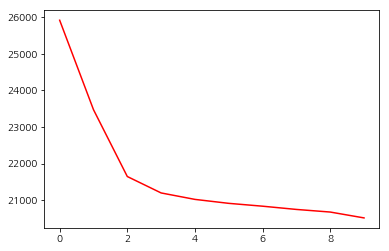

In [73]:
plt.plot(range(len(sseList)), sseList, "r-")

#### 시각화

In [74]:
clusterDataset = list()

for j, c in enumerate(cluster):
    dataset = [i for i in range(N) if rnk[i][j]]
    clusterDataset.append(dataset)

In [75]:
voca = list(twm.keys())
topic = list()

for c in cluster:
    wordList = defaultdict(float)
    
    for i, w in enumerate(c):
        wordList[voca[i]] = w
        
    topic.append(dict(sorted(wordList.items(), key=lambda x: x[1], reverse=True)[:100]))    # {word, value}
    print(sorted(wordList, key=wordList.get, reverse=True)[:20])      # [word]

['요금', '폴드', '인구', '애플', '결제', '인천', '청약', '게임', '더블', '특허', '아동', '현대', '5G', '항공', '저축', '롯데', '반도체', '이사', '수술', '작가']
['뉴스', '있다', '라고', '서울', '했다', '10', '20', '다는', '면서', '있는', '지만', '채널', '다고', '한다', 'ㄴ다', '까지', '지난', '금지', '이다', '전재']
['5G', '회장', '의원', '화면', '북한', '후보', '장관', '연금', '경찰', '중국', '일본', '삼성', '후보자', '여성', '선거', '애플', '직원', '자료', '달러', '앵커']
['중국', '경찰', '습니', '의원', '지역', '당시', '습니다', '시장', '수사', '아이', '미국', '기업', '국내', '전자', '올해', '사용', '사건', '혐의', '대통령', '장관']
['한국', '니다', '사진', '미국', '관련', '서울', '지난해', '정부', '최근', '우리', '시간', '이상', '이후', '문제', '이날', '때문', '경제', '사람', '조사', '습니다']
['나토', '면세', '이궁', '로봇', '두릅', '연호', '패드', '김밥', '탁신', '남편', '총기', '화산', '프림', '트뤼', '따이', 'YG', '아람', '면세점', '통영', '공매']


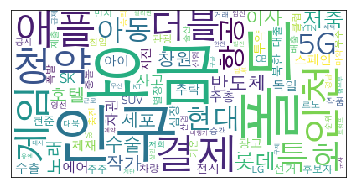

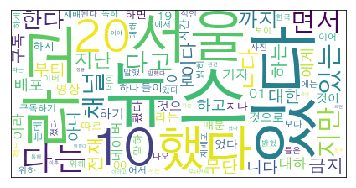

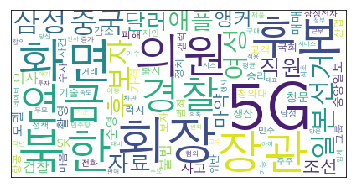

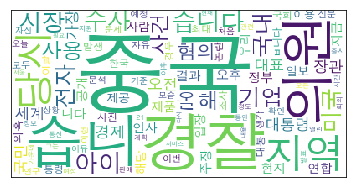

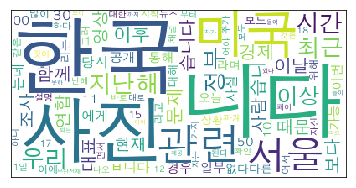

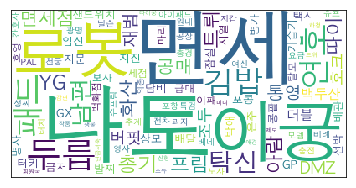

In [76]:
from wordcloud import  WordCloud

fontPath = "Libray/Fonts/AppleGothic.ttf"
wc = WordCloud(font_path=fontPath, background_color="white")

for _ in range(len(topic)):
    wc.generate_from_frequencies(topic[_])
    plt.imshow(wc)
    plt.xticks([])
    plt.yticks([])
    plt.show()